In [1]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
from collections import OrderedDict
import datetime
import time
import matplotlib.pyplot as plt
sys.path.append('../etf_tools/')
sys.path.append('./modeling/lstm/')

from ml import (
    EstimatorBucket,
    prepare_etf, 
    prepare_etf_gen,
    evaluate_stacking
)

from utils import (
    ez_plot
)

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.utils import shuffle as sk_shuffle

plt.style.use('ggplot')
plt.ioff()

In [2]:
code_list = ['0050', '0051', '0052', '0053', '0054']
src_dir = '/root/work/stock-groupbycode/trainingset/'

In [3]:
sample_file = [os.path.join(src_dir, f'{code}.csv') for code in code_list]

In [4]:
# Selected features

feature_basic = ['k', 'd', 'open_gap', 'rsi', 'obv','vr','volume', 'kbody', 'up_shadow', 'low_shadow','macd',
                'dif', 'ema12', 'ema26']
feature_all = [
    'k', 'd', 'open_gap', 'rsi', 'obv','vr','volume', 'kbody', 'up_shadow', 'low_shadow','macd',
    'kd_diff', # k - d
    'macd_diff', # dif - macd
    'em_diff' # ema12 - ema26
]

# Selected targets
label_cols = ['y_5']

cate_feature_cols = [f'month_{i + 1}' for i in range(12)] + [f'week_{i + 1}' for i in range(5)]

In [5]:
etf_list = [pd.read_csv(_file).dropna(subset=label_cols) for _file in sample_file]

In [7]:
label_cols

['y_5']

In [21]:
for etf in etf_list:
    etf['target'] = np.where((etf[label_cols[0]] - etf['close']).fillna(0)>=0, 1, 0)

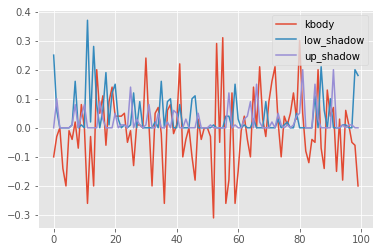

In [23]:
plt.plot(etf['kbody'][0:100], label='kbody')
plt.plot(etf['low_shadow'][0:100], label='low_shadow')
plt.plot(etf['up_shadow'][0:100], label='up_shadow')
plt.legend(loc=0)
plt.show()

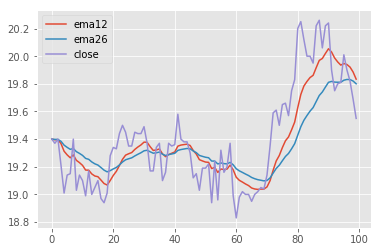

In [24]:
plt.plot(etf['ema12'][0:100], label='ema12')
plt.plot(etf['ema26'][0:100], label='ema26')
plt.plot(etf['close'][0:100], label='close')  
plt.legend(loc=0)
plt.show()

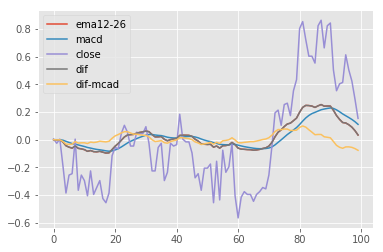

In [25]:
plt.plot(etf['ema12'][0:100] - etf['ema26'][0:100], label='ema12-26')
plt.plot(etf['macd'][0:100], label='macd')
plt.plot(etf['close'][0:100] - etf['close'][0:100].mean(), label='close')
plt.plot(etf['dif'][0:100], label='dif')
plt.plot(etf['dif'][0:100] - etf['macd'][0:100], label='dif-mcad')
plt.legend(loc=0)
plt.show()

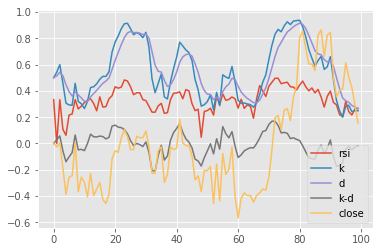

In [26]:
plt.plot(etf['rsi'][0:100], label='rsi')
plt.plot(etf['k'][0:100], label='k')
plt.plot(etf['d'][0:100], label='d')
plt.plot(etf['k'][0:100] - etf['d'][0:100], label='k-d')
plt.plot(etf['close'][0:100] - etf['close'][0:100].mean(), label='close')
plt.legend(loc=0)
plt.show()

In [27]:
# Hyperparams
feature_dim = len(feature_all)
num_classes = len(label_cols)
timestamp = window = 5
batchsize = 32
#epochs = 500
#dropout = 0.6
#n_experiment = 10

In [28]:
def cnn_feature_trans(df):
    conts = df[feature_all]
    norms = ((conts - conts.mean()) / conts.std()).fillna(0)
    norms_minmax = (norms - norms.min()) / (norms.max() - norms.min())
    return conts

In [30]:
train_etf_list = []
for etf in etf_list:
    basic_etf = etf[feature_basic + ['target']]
    basic_etf['kd_diff'] = basic_etf['k'] - basic_etf['d']
    basic_etf['macd_diff'] = basic_etf['dif'] - basic_etf['macd']
    basic_etf['em_diff'] = basic_etf['ema12'] - basic_etf['ema26']
    basic_etf = basic_etf.drop(['ema12','ema26','dif'], 1)
    train_etf_list.append(basic_etf)

/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [34]:
train_data = []
for _etf in train_etf_list:
    X_all, y_all = prepare_etf(basic_etf, 
                           feature_cols = feature_all, 
                           label_cols = ['target'], 
                           window=window,
                           feature_trans=cnn_feature_trans)
    y_all = np.vstack(y_all).astype(np.int64)
    train_data.append((X_all, y_all))

In [35]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)

(1308, 5, 14)
(1308, 1)


In [45]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1294, 5, 14)
(1294, 1)
(14, 5, 14)
(14, 1)


In [38]:
import keras
import keras.backend as K  # noqa
from keras.models import Sequential, Model
import keras.layers
from keras.layers import (
    Input, Embedding, LSTM, Lambda, Conv1D,
    Dense, Dropout, Activation, Reshape, MaxPooling1D, Flatten
)
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

In [39]:
class NNFactory_IPY(object):

    def __init__(self, input_shape, num_classes, activation='sigmoid', output_activation=None, dropout=0.1):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.activation = activation
        self.dropout = dropout
        self.output_activation = (output_activation if output_activation is not None 
                                                    else ('sigmoid' if self.num_classes == 1 else 'softmax'))

    def __call__(self, do_compile=True):
        # TODO: should I cache model?
        model = self.create()

        if do_compile:
            return self.compile(model)
        else:
            return model

    def getnet(self, name):
        try:
            return self.__getattribute__(name)
        except Exception:
            raise AttributeError(f'Network "{self.__name__}" has no subnet named "{name}".')

    def create(self):
        raise NotImplementedError

    def compile(self, model, **kwargs):
        model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics,
            **kwargs
        )

        return model


In [40]:
class EtfCNNFactory_IPY(NNFactory_IPY):
    def __init__(self, *args, recurrent_activation='hard_sigmoid', **kwargs):
        """
        Params:
            input_shape:
            num_classes:
            activation:
            recurrent_activation:
            output_activation:
            dropout:
        """
        super().__init__(*args, **kwargs)
        self.recurrent_activation = recurrent_activation

    def create(self, optimizer='adam', loss=binary_crossentropy, metrics=['accuracy']):
        x = Input(shape=self.input_shape)
        print(self.input_shape)
        
        c1 = Conv1D(24, kernel_size=3, strides=1, padding='same', 
                    input_shape=self.input_shape, activation='relu', name='c1')       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
        c2 = Conv1D(24, kernel_size=3, strides=1, padding='same', activation='relu', name='c2')       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
        m1 = MaxPooling1D(2, strides=2, name='block1_pool')
        c3 = Conv1D(24, kernel_size=5, strides=1, padding='same', activation='relu', name='c3')       # 64 features, 5px5p kernal window, 2wx2h stride, relu
        c4 = Conv1D(24, kernel_size=5, strides=1, padding='same', activation='relu', name='c4')       # 64 features, 3px3p kernal window, 1wx1h stride, relu
        m2 = MaxPooling1D(2, strides=2, name='block2_pool')
        d1 = Dropout(0.2)
        ff = Flatten(name='flatten')
        fc1 = Dense(64, activation='relu', name='fc1')
        d2 = Dropout(0.2)
        fc2 = Dense(32, activation='relu', name='fc2')
        d3 = Dropout(0.1)
        out = Dense(self.num_classes, activation='sigmoid', name='out')
        
        
        pipes = [c1, c2, m1, c3, c4, m2, d1, ff, fc1, d2, fc2, d3, out]
        #pipes = [c1, c2, m1, d1, ff, fc1, d2, fc2, d3, out]
        
        h = x
        for f in pipes:
            h = f(h)
        y = h

        model = Model(x, y)
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
        return model

In [41]:
class EtfLSTMFactory_IPY(NNFactory_IPY):
    def __init__(self, *args, recurrent_activation='hard_sigmoid', **kwargs):
        """
        Params:
            input_shape:
            num_classes:
            activation:
            recurrent_activation:
            output_activation:
            dropout:
        """
        super().__init__(*args, **kwargs)
        self.recurrent_activation = recurrent_activation

    def create(self, optimizer='adam',
               loss=binary_crossentropy,
               metrics=['accuracy']):
        x = Input(shape=self.input_shape)

        ly1 = LSTM(128, return_sequences=True,
                   dropout=self.dropout,
                   activation=self.activation,
                   recurrent_activation=self.recurrent_activation)
        ly2 = LSTM(128, return_sequences=False,
                   dropout=self.dropout,
                   activation=self.activation,
                   recurrent_activation=self.recurrent_activation)
        ly3 = Dense(64, activation=self.activation)
        ly4 = Dropout(self.dropout)
        ly5 = Dense(32, activation=self.activation)
        ly6 = Dropout(self.dropout)
        out = Dense(self.num_classes, activation='sigmoid', name='out')

        pipes = [ly1, ly2, ly3, ly4, ly5, ly6, out]

        h = x
        for f in pipes:
            h = f(h)
        y = h
        

        model = Model(x, y)
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
        return model


In [53]:
build_cnn = EtfCNNFactory_IPY((timestamp, feature_dim), num_classes, activation='relu')
build_lstm = EtfLSTMFactory_IPY((timestamp, feature_dim), num_classes, activation='relu')

model_cnn = build_cnn()
model_lstm = build_lstm()
model_cnn.summary()

(5, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 14)             0         
_________________________________________________________________
c1 (Conv1D)                  (None, 5, 24)             1032      
_________________________________________________________________
c2 (Conv1D)                  (None, 5, 24)             1752      
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 2, 24)             0         
_________________________________________________________________
c3 (Conv1D)                  (None, 2, 24)             2904      
_________________________________________________________________
c4 (Conv1D)                  (None, 2, 24)             2904      
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 1, 24)             0         
__

In [66]:
def patched_f1_score(threshold=0.5):
    def val_f1(y_actual, y_pred):
        yp = 1 * (y_pred >= threshold)
        return f1_score(y_actual, yp)
    return val_f1

In [67]:
def patched_accuracy_score(threshold=0.5):
    def val_acc(y_actual, y_pred):
        yp = 1 * (y_pred >= threshold)
        return accuracy_score(y_actual, yp)
    return val_acc

In [57]:
X_all = train_data[1][0]
y_all = train_data[1][1]

In [58]:
(X_train, y_train), (X_val, y_val) = sk_shuffle(X_all[:-X_all.shape[0] // 100], y_all[:-X_all.shape[0] // 100]), \
                                                (X_all[-X_all.shape[0] // 100:], y_all[-X_all.shape[0] // 100:])

#(X_train, y_train), (X_val, y_val) = sk_shuffle(X_all[:-10], y_all[:-10]), \
#                                                (X_all[-10:], y_all[-10:])

In [59]:
y_val.shape

(14, 1)

In [60]:
n_experiment = 1
epochs = 1000
this_dir = '/root/work/twetf/ryan'

In [61]:
y_train[0]

array([1])

In [ ]:
for i in range(n_experiment):
    #model = build_fn()
    #evaluate_path = f'evaluate/metrics.{code}.{now.date().isoformat()}.{i}.csv'
    '''
    csv_logger = BatchCSVLogger(evaluate_path, skip=100,
                                x_val=X_val, y_val=y_val, 
                                metrics=[patched_accuracy_score(threshold=0.5), 
                                         patched_f1_score(threshold=0.5)])
    
    tags = OrderedDict(code=code, datemark='20180530', n_exp=(i+1))
    
    csv_logger = EtfCkptLogger(model, tags=tags, metrics_path=metrics_path,
                                   x_val=X_val, y_val=y_val)

    '''
    history = model_cnn.fit(x=X_train, y=y_train, epochs=epochs,
                        batch_size=batchsize,
                        validation_data=(X_val, y_val))

Train on 1294 samples, validate on 14 samples
Epoch 1/1000
1294/1294 [==============================] - 4s 3ms/step - loss: 7.0779 - acc: 0.5162 - val_loss: 5.6937 - val_acc: 0.6429
Epoch 2/1000
1294/1294 [==============================] - 0s 271us/step - loss: 7.0401 - acc: 0.5440 - val_loss: 5.6937 - val_acc: 0.6429
Epoch 3/1000
1294/1294 [==============================] - 0s 238us/step - loss: 6.9367 - acc: 0.5070 - val_loss: 10.3616 - val_acc: 0.3571
Epoch 4/1000
1294/1294 [==============================] - 0s 203us/step - loss: 5.4644 - acc: 0.4946 - val_loss: 0.6949 - val_acc: 0.6429
Epoch 5/1000
1294/1294 [==============================] - 0s 246us/step - loss: 1.0454 - acc: 0.5185 - val_loss: 0.6892 - val_acc: 0.4286
Epoch 6/1000
1294/1294 [==============================] - 0s 238us/step - loss: 0.7069 - acc: 0.5077 - val_loss: 0.6887 - val_acc: 0.6429
Epoch 7/1000
1294/1294 [==============================] - 0s 250us/step - loss: 0.6898 - acc: 0.5456 - val_loss: 0.6829 - val_a

1294/1294 [==============================] - 0s 267us/step - loss: 0.6807 - acc: 0.5471 - val_loss: 0.6726 - val_acc: 0.6429
Epoch 60/1000
1294/1294 [==============================] - 0s 212us/step - loss: 0.6821 - acc: 0.5487 - val_loss: 0.6731 - val_acc: 0.6429
Epoch 61/1000
1294/1294 [==============================] - 0s 229us/step - loss: 0.6815 - acc: 0.5471 - val_loss: 0.6738 - val_acc: 0.6429
Epoch 62/1000
1294/1294 [==============================] - 0s 282us/step - loss: 0.6818 - acc: 0.5471 - val_loss: 0.6732 - val_acc: 0.6429
Epoch 63/1000
1294/1294 [==============================] - 0s 230us/step - loss: 0.6814 - acc: 0.5487 - val_loss: 0.6745 - val_acc: 0.6429
Epoch 64/1000
1294/1294 [==============================] - 0s 194us/step - loss: 0.6832 - acc: 0.5502 - val_loss: 0.6725 - val_acc: 0.6429
Epoch 65/1000
1294/1294 [==============================] - 0s 211us/step - loss: 0.6792 - acc: 0.5518 - val_loss: 0.6734 - val_acc: 0.6429
Epoch 66/1000
1294/1294 [================

Epoch 118/1000
1294/1294 [==============================] - 0s 254us/step - loss: 0.6811 - acc: 0.5502 - val_loss: 0.6723 - val_acc: 0.6429
Epoch 119/1000
1294/1294 [==============================] - 0s 207us/step - loss: 0.6805 - acc: 0.5510 - val_loss: 0.6730 - val_acc: 0.6429
Epoch 120/1000
1294/1294 [==============================] - 0s 225us/step - loss: 0.6808 - acc: 0.5510 - val_loss: 0.6722 - val_acc: 0.6429
Epoch 121/1000
1294/1294 [==============================] - 0s 242us/step - loss: 0.6811 - acc: 0.5510 - val_loss: 0.6714 - val_acc: 0.6429
Epoch 122/1000
1294/1294 [==============================] - 0s 239us/step - loss: 0.6807 - acc: 0.5502 - val_loss: 0.6720 - val_acc: 0.6429
Epoch 123/1000
1294/1294 [==============================] - 0s 278us/step - loss: 0.6801 - acc: 0.5510 - val_loss: 0.6722 - val_acc: 0.6429
Epoch 124/1000
1294/1294 [==============================] - 0s 261us/step - loss: 0.6807 - acc: 0.5510 - val_loss: 0.6709 - val_acc: 0.6429
Epoch 125/1000
1294/